In [3]:
from fvgp import GP
import numpy as np
import random
import matplotlib.pyplot as plt
import time 


%load_ext autoreload
%autoreload 2
from itertools import product
x_pred1D = np.linspace(0,5,1000).reshape(-1,1) # adjusted this to 0,5,100 instead of 0,1,1000

The power Law funtion:
$$
y = ax^p + b
$$

The main objective of this exercise is to be able to predict the cycle number as a function of r using Gaussian Processes, no matter what the shape is, we don't care about the shape

In [24]:
#######################
## Creating the data ##
#######################

radii = np.array([[round(random.uniform(0,5), 2)] for _ in range(10)])
print('Radii: ', radii)

# Arbitrarily fix the paramets of the power Lo function
a = 1
p = 2
b = -5
def power_lo(x):
    return a * x ** p + b

def data_noise(lowerbound=-3.0, upperbound=3.0): # noise for the data collection
    return random.uniform(lowerbound, upperbound)

cycles = np.array([round(power_lo(r[0]) + data_noise(), 3) for r in radii])
# cycles = np.array([round(power_lo(r[0]), 3) for r in radii])
print('Cycles: ', cycles)

Radii:  [[3.58]
 [4.15]
 [1.2 ]
 [1.03]
 [0.08]
 [1.14]
 [0.67]
 [0.24]
 [0.49]
 [1.73]]
Cycles:  [10.104 14.834 -3.075 -6.226 -4.046 -3.945 -2.128 -4.832 -4.784 -0.782]


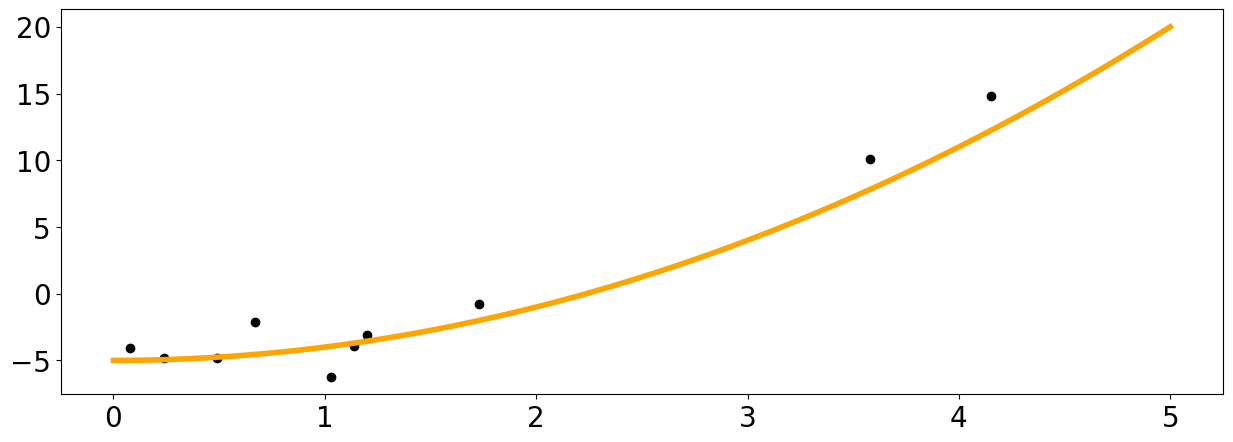

In [25]:
##########
## Data ##
##########
# x = np.linspace(0,600,1000)
f1 = power_lo # set f1 to power_lo because they call it f1 in the example
 
x_data = radii  # this as well
y_data = cycles

plt.figure(figsize = (15,5))
plt.xticks([0.,5.0,1.0, 2.0, 3.0, 4.0])
plt.yticks([-10,-5,0,5,10,15,20,25])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data[:,0],y_data, color = 'black')

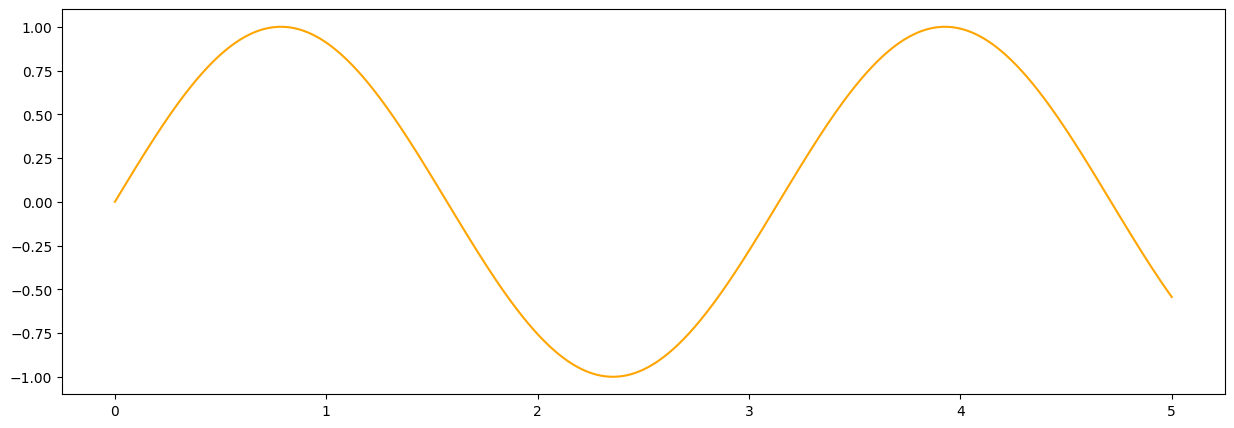

In [41]:
########################
## Customizing the GP ##
########################

from fvgp.gp_kernels import *
def my_noise(x,hps):
    #This is a simple noise function but can be arbitrarily complex using many hyperparameters.
    #The noise function always has to return a matrix, because the noise can have covariances.
    return np.diag(np.ones((len(x))) * hps[2])

#stationary
def skernel(x1,x2,hps):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])


def meanf(x, hps):
    #This ios a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return np.sin(hps[3] * x[:,0])
#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.])), color = 'orange', label = 'task1')

In [42]:
###################################################
## Initialization and different training options ##
###################################################
my_gp1 = GP(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # we need enough of those for kernel, noise and prior mean functions
            # noise_variances=np.ones(y_data.shape) * 0.01, #provding noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            gp_kernel_function=skernel, 
            gp_kernel_function_grad=None, 
            gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            gp_noise_function=my_noise,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=False, 
            args=None,
            )


hps_bounds = np.array([[0.01,100.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.1,10],  #noise
                       [0.01,1.]  #mean
                      ])

# my_gp1.update_gp_data(x_data, y_data, noise_variances_new=np.ones(y_data.shape) * 0.01)

# print("Standard Training")
# my_gp1.train(hyperparameter_bounds=hps_bounds)

print("Global Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='global')
print("hps: ", my_gp1.get_hyperparameters())

# print("Local Training")
# my_gp1.train(hyperparameter_bounds=hps_bounds, method='local')
# print(my_gp1.get_hyperparameters())

# print("MCMC Training")
# my_gp1.train(hyperparameter_bounds=hps_bounds, method='mcmc', max_iter=1000)

# print("HGDL Training")
# print(my_gp1.get_hyperparameters())
# my_gp1.train(hyperparameter_bounds=hps_bounds, method='hgdl', max_iter=10)

Global Training
hps:  [99.99039972  3.77269227  1.92889038  0.29457595]


1.8138243980879778
(7.430881373296732, 5.94446601540068)


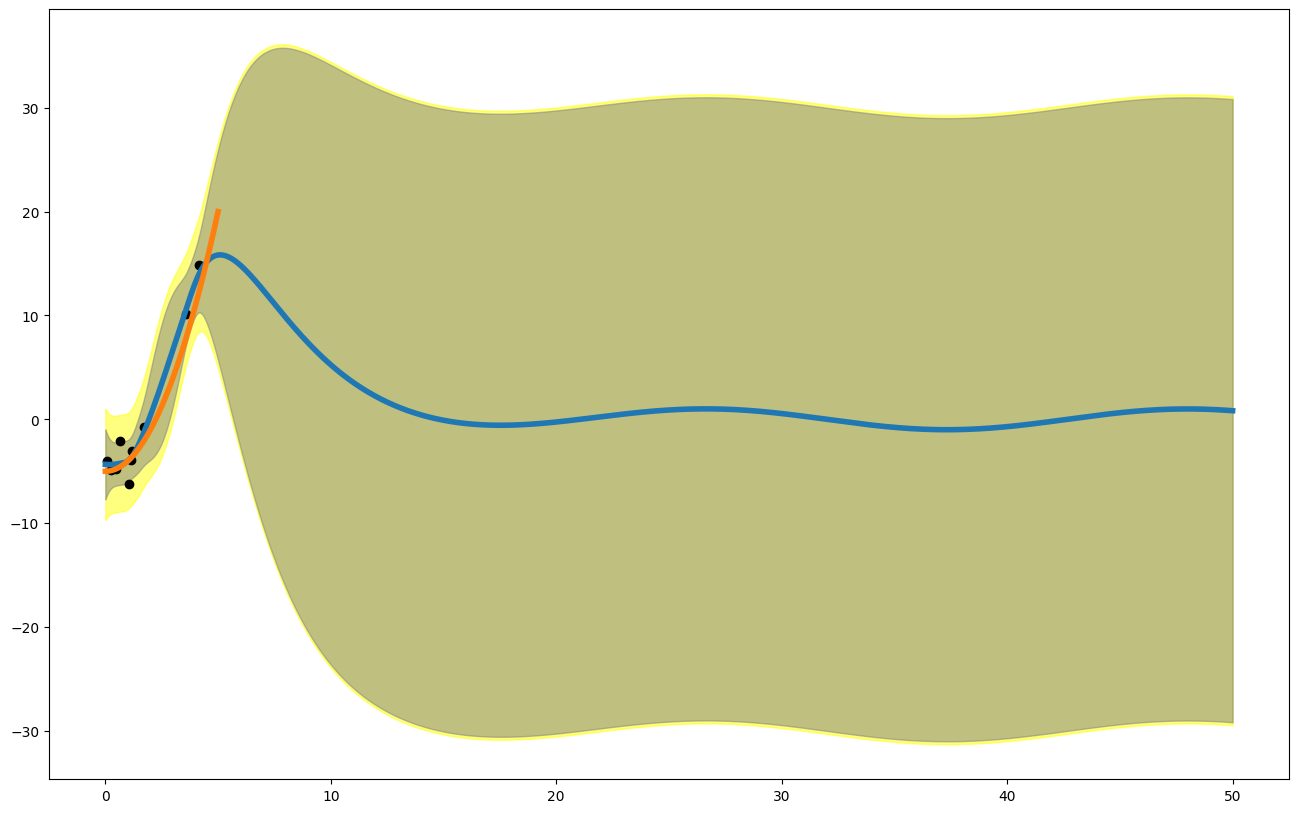

In [44]:
#let's make a prediction
x_pred = np.linspace(0,50,1000)

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=False)["v(x)"]
var2 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)


plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var2), mean1 + 3. * np.sqrt(var2), alpha = 0.5, color = "yellow", label = "var")
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")

plt.scatter(x_data,y_data, color = 'black')


##looking at some validation metrics
print(my_gp1.rmse(x_pred1D,f1(x_pred1D)))
print(my_gp1.crps(x_pred1D,f1(x_pred1D)))

In [ ]:
# K(xi,xj) this is prior which you use to 